In [2]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from pymongo import MongoClient

In [3]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [4]:
db = client["forex_data"]
collections = db.list_collection_names()

In [5]:
# Choose a collection (for example EUR_GBP_D)
collection_name = "EUR_GBP_D"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURGBP_D = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURGBP_D.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURGBP_D["open"] = df_EURGBP_D["mid"].apply(lambda x: float(x["o"]))
df_EURGBP_D["high"] = df_EURGBP_D["mid"].apply(lambda x: float(x["h"]))
df_EURGBP_D["low"] = df_EURGBP_D["mid"].apply(lambda x: float(x["l"]))
df_EURGBP_D["close"] = df_EURGBP_D["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURGBP_D = df_EURGBP_D[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURGBP_D)}")
print("\nFirst few rows:")
print(df_EURGBP_D.head())


DataFrame info for EUR_GBP_D:
Total number of candles: 2598

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-15 22:00:00   26777  0.73891  0.74276  0.73784  0.73894
2015-02-16 22:00:00   21534  0.73889  0.74440  0.73750  0.74320
2015-02-17 22:00:00   23410  0.74344  0.74374  0.73480  0.73826
2015-02-18 22:00:00   22054  0.73835  0.74094  0.73570  0.73744
2015-02-19 22:00:00   34402  0.73754  0.74296  0.73402  0.73886


In [12]:
import numpy as np


def identify_multiple_ma_crossovers(df, ma_pairs):
    """
    Identify MA crossover signals for multiple MA combinations

    Parameters:
    df : pandas DataFrame with price data
    ma_pairs : list of tuples, each containing (fast_period, slow_period)

    Returns:
    DataFrame with signals for each MA combination
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Calculate all required MAs
    for fast, slow in ma_pairs:
        df[f"SMA_{fast}"] = df["close"].rolling(window=fast).mean()
        df[f"SMA_{slow}"] = df["close"].rolling(window=slow).mean()

        # Generate signals for this MA pair
        signal_col = f"signal_{fast}_{slow}"
        df[signal_col] = np.where(
            (df[f"SMA_{fast}"] > df[f"SMA_{slow}"])
            & (df[f"SMA_{fast}"].shift(1) <= df[f"SMA_{slow}"].shift(1)),
            1,  # Buy signal
            np.where(
                (df[f"SMA_{fast}"] < df[f"SMA_{slow}"])
                & (df[f"SMA_{fast}"].shift(1) >= df[f"SMA_{slow}"].shift(1)),
                -1,  # Sell signal
                0,  # No signal
            ),
        )

    return df


# Example usage:
ma_pairs = [
    (60, 10),
    (60, 40),
    (70, 10),
    (40, 30),
    (80, 10),
    (100, 50),
    (90, 20),
    (80, 30),
    (160, 20),
    (50, 40),
]


# Apply to your DataFrame
df_with_signals = identify_multiple_ma_crossovers(df_EURGBP_D, ma_pairs)

# Print columns with signals
signal_columns = [col for col in df_with_signals.columns if col.startswith("signal_")]
print("\nSignal columns created:")
for col in signal_columns:
    print(f"- {col}")

# Example: Count signals for each MA pair
for col in signal_columns:
    buy_signals = (df_with_signals[col] == 1).sum()
    sell_signals = (df_with_signals[col] == -1).sum()
    print(f"\n{col}:")
    print(f"Buy signals: {buy_signals}")
    print(f"Sell signals: {sell_signals}")


Signal columns created:
- signal_60_10
- signal_60_40
- signal_70_10
- signal_40_30
- signal_80_10
- signal_100_50
- signal_90_20
- signal_80_30
- signal_160_20
- signal_50_40

signal_60_10:
Buy signals: 40
Sell signals: 40

signal_60_40:
Buy signals: 32
Sell signals: 33

signal_70_10:
Buy signals: 37
Sell signals: 38

signal_40_30:
Buy signals: 47
Sell signals: 48

signal_80_10:
Buy signals: 35
Sell signals: 35

signal_100_50:
Buy signals: 14
Sell signals: 14

signal_90_20:
Buy signals: 20
Sell signals: 21

signal_80_30:
Buy signals: 23
Sell signals: 24

signal_160_20:
Buy signals: 16
Sell signals: 15

signal_50_40:
Buy signals: 42
Sell signals: 43


In [13]:
def backtest_multiple_signals(df, signal_columns):
    """
    Backtest trades based on multiple MA crossover signals.
    Returns a dictionary of results for each MA combination.
    """
    results = {}

    for signal_col in signal_columns:
        trades = []
        open_trade = None

        # Create a copy of DataFrame for this signal
        df_temp = df.copy()

        for time, row in df_temp.iterrows():
            signal = row[signal_col]
            price = row["close"]

            # If there is a signal (non-zero)
            if signal != 0:
                # If no trade is open, open one
                if open_trade is None:
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }
                # If a trade is already open and the new signal is different (a reversal)
                elif signal != open_trade["signal"]:
                    exit_price = price
                    exit_time = time
                    if open_trade["signal"] == 1:  # Buy trade
                        pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                    else:  # Sell trade
                        pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                    trade = {
                        "entry_time": open_trade["entry_time"],
                        "exit_time": exit_time,
                        "entry_price": open_trade["entry_price"],
                        "exit_price": exit_price,
                        "signal": open_trade["signal"],
                        "pip_gain": pip_gain,
                    }
                    trades.append(trade)
                    # Open a new trade with the current signal
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }

        # If a trade is still open at the end, close it
        if open_trade is not None:
            last_time = df_temp.index[-1]
            last_price = df_temp.iloc[-1]["close"]
            if open_trade["signal"] == 1:
                pip_gain = (last_price - open_trade["entry_price"]) * 10000
            else:
                pip_gain = (open_trade["entry_price"] - last_price) * 10000
            trade = {
                "entry_time": open_trade["entry_time"],
                "exit_time": last_time,
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
            trades.append(trade)

        # Store results for this MA combination
        if trades:
            trades_df = pd.DataFrame(trades)
            total_pips = trades_df["pip_gain"].sum()
            num_trades = len(trades_df)
            avg_pips = trades_df["pip_gain"].mean()
            win_rate = (trades_df["pip_gain"] > 0).mean()

            results[signal_col] = {
                "trades": trades_df,
                "total_pips": total_pips,
                "num_trades": num_trades,
                "avg_pips": avg_pips,
                "win_rate": win_rate,
            }

    return results


# Run backtest for all MA combinations
results = backtest_multiple_signals(df_with_signals, signal_columns)

# Print summary of results for each MA combination
print("\nBacktest Results Summary:")
print("-" * 80)
summary_data = []
for ma_combo, result in results.items():
    summary_data.append(
        {
            "MA_Combo": ma_combo,
            "Total_Trades": result["num_trades"],
            "Total_Pips": round(result["total_pips"], 1),
            "Avg_Pips": round(result["avg_pips"], 1),
            "Win_Rate": f"{result['win_rate']*100:.1f}%",
        }
    )

# Convert to DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)
print(summary_df)


Backtest Results Summary:
--------------------------------------------------------------------------------
        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
0   signal_60_10            80      6199.8      77.5    80.0%
1   signal_60_40            65      4664.6      71.8    69.2%
2   signal_70_10            75      4596.8      61.3    76.0%
3   signal_40_30            95      4562.6      48.0    58.9%
4   signal_80_10            70      4357.4      62.2    80.0%
6   signal_90_20            41      3963.6      96.7    78.0%
7   signal_80_30            47      3893.6      82.8    68.1%
9   signal_50_40            85      3492.1      41.1    63.5%
5  signal_100_50            28      3394.6     121.2    60.7%
8  signal_160_20            31      2295.5      74.0    80.6%


In [11]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)

# Display full results
print(summary_df)

# Optional: Reset display options to default after viewing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')

         MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
4    signal_60_10            80     6199.80     77.50    80.0%
55   signal_60_40            65     4664.60     71.80    69.2%
5    signal_70_10            75     4596.80     61.30    76.0%
37   signal_40_30            95     4562.60     48.00    58.9%
6    signal_80_10            70     4357.40     62.20    80.0%
21   signal_50_20            65     4155.70     63.90    75.4%
3    signal_50_10            88     4112.30     46.70    76.1%
8   signal_100_10            58     4029.90     69.50    74.1%
22   signal_60_20            61     3993.80     65.50    73.8%
25   signal_90_20            41     3963.60     96.70    78.0%
41   signal_80_30            47     3893.60     82.80    68.1%
7    signal_90_10            60     3761.30     62.70    83.3%
38   signal_50_30            65     3722.70     57.30    70.8%
26  signal_100_20            37     3713.80    100.40    78.4%
39   signal_60_30            59     3615.80     61.30  

In [14]:
def calculate_atr(df, period=14):
    """
    Calculate Average True Range (ATR)

    Parameters:
    - df: DataFrame with high, low, close prices
    - period: Period for ATR calculation, default 14

    Returns:
    - Series containing ATR values
    """
    df = df.copy()

    # Calculate True Range
    df["tr1"] = df["high"] - df["low"]
    df["tr2"] = abs(df["high"] - df["close"].shift(1))
    df["tr3"] = abs(df["low"] - df["close"].shift(1))

    df["tr"] = df[["tr1", "tr2", "tr3"]].max(axis=1)

    # Calculate ATR
    atr = df["tr"].rolling(window=period).mean()

    return atr


Realistic Backtest Results:
Total Trades: 80
Total Pips: 980.9
Average Pips per Trade: 12.3
Win Rate: 50.0%
Sharpe Ratio: 4.19

Exit Analysis:
----------------------------------------
Exit Type Distribution:
sl: 40 trades (0.0% win rate)
tp: 40 trades (100.0% win rate)

Risk Metrics:
----------------------------------------
Profit Factor: 1.77
Maximum Drawdown: 171.1 pips


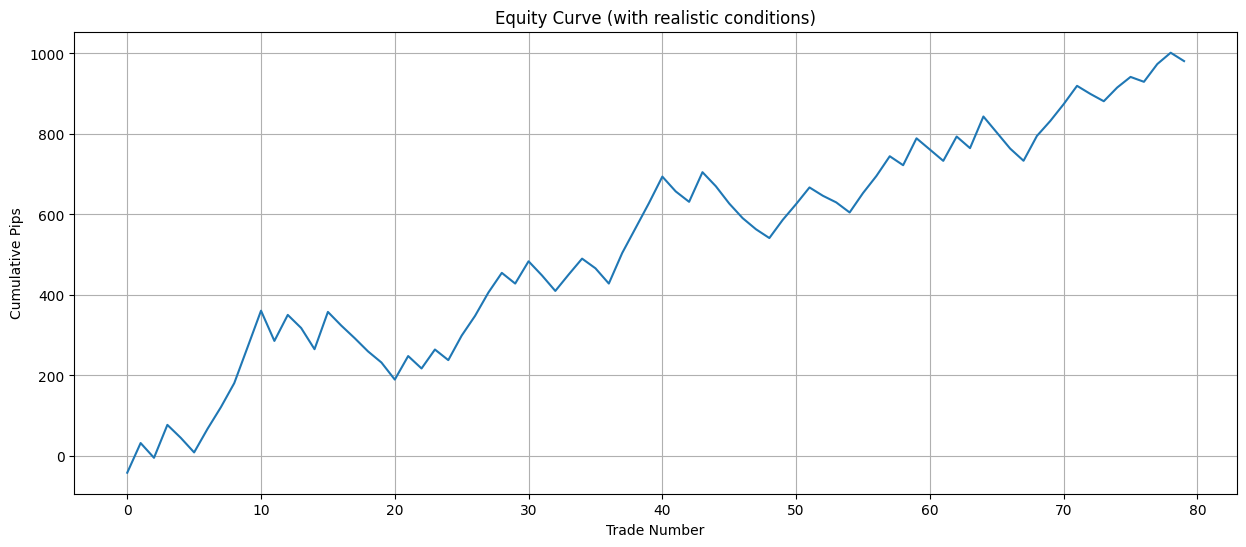

In [30]:
# Import plotting library
import matplotlib.pyplot as plt


def realistic_backtest_with_risk_management(
    df, signal_col, spread_pips=1.0, tp_atr=1.0, sl_atr=0.5, atr_period=14
):
    """
    Add ATR-based stops and targets to realistic backtest
    """
    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        # Handle open trade
        if open_trade is not None:
            # Calculate take-profit and stop-loss levels
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] - (current_atr * sl_atr)
                # Check if TP or SL hit
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] + (current_atr * sl_atr)
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue

            pip_gain = (exit_price - open_trade["entry_price"]) * 10000
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        # Open new trade
        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]  # Use next bar's open for entry
            if signal == 1:
                entry_price += spread_pips * 0.0001  # Add spread for buying
            else:
                entry_price -= spread_pips * 0.0001  # Subtract spread for selling

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    # Close any remaining trade
    if open_trade is not None:
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            last_price -= spread_pips * 0.0001
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            last_price += spread_pips * 0.0001
            pip_gain = (open_trade["entry_price"] - last_price) * 10000

        trades.append(
            {
                "entry_time": open_trade["entry_time"],
                "exit_time": df.index[-1],
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
        )

    trades_df = pd.DataFrame(trades)

    # Calculate daily returns for Sharpe Ratio
    if not trades_df.empty:
        daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = np.sqrt(252) * avg_return / std_return if std_return != 0 else 0

        results = {
            "total_pips": trades_df["pip_gain"].sum(),
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pip_gain"] > 0).mean(),
            "avg_pips": trades_df["pip_gain"].mean(),
            "sharpe_ratio": sharpe_ratio,
            "trades": trades_df,
        }
    else:
        results = {
            "total_pips": 0,
            "num_trades": 0,
            "win_rate": 0,
            "avg_pips": 0,
            "sharpe_ratio": 0,
            "trades": trades_df,
        }

    return results


# Run realistic backtest
realistic_results = realistic_backtest_with_risk_management(
    # Make sure to change this to the correct signal column
    df_with_signals,
    "signal_60_10",
)

print("\nRealistic Backtest Results:")
print(f"Total Trades: {realistic_results['num_trades']}")
print(f"Total Pips: {realistic_results['total_pips']:.1f}")
print(f"Average Pips per Trade: {realistic_results['avg_pips']:.1f}")
print(f"Win Rate: {realistic_results['win_rate']*100:.1f}%")
print(f"Sharpe Ratio: {realistic_results['sharpe_ratio']:.2f}")

# After the existing results printing
if len(realistic_results["trades"]) > 0:
    trades_df = realistic_results["trades"]

    # Exit type analysis
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    print("\nExit Analysis:")
    print("-" * 40)
    print("Exit Type Distribution:")
    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        print(f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate)")

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 40)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")

# Plot equity curve
if len(realistic_results["trades"]) > 0:
    plt.figure(figsize=(15, 6))
    equity_curve = realistic_results["trades"]["pip_gain"].cumsum()
    plt.plot(equity_curve.index, equity_curve)
    plt.title("Equity Curve (with realistic conditions)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()